In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
torch.__version__
torchvision.__version__

'0.21.0+cu124'

## 2. Setup Device - Agnostic Code


In [3]:
!nvidia-smi


Fri Jul 18 07:07:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
torch.cuda.is_available()


True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##3. Set the seed


In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)


##4.Setting the hyperparameters


In [7]:
BATCH_SIZE=128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE=32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

##5. Define Image Transformations


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
    #helps the model to convert faster
    #helps to make the numerical computations stable (normalize)
])

##6. Getting a dataset

In [9]:
train_dataset = datasets.CIFAR10(root = "data",
                                 train = True,
                                 download = True,
                                 transform = transform

                                 )

100%|██████████| 170M/170M [00:02<00:00, 67.8MB/s]


In [10]:
test_dataset = datasets.CIFAR10(root = "data",
                                train = False,
                                download = True,
                                transform = transform
                                )

In [11]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [12]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

## 7. Converting our datasets into dataloaders

Dataloader turns our data into mini batches.
1. Its more computationally efficient, as in ,your computing hardware may not be able to look (store in memory) at 50000 images in one hit. So we can break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradient per epoch.

In [13]:
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)


In [14]:
# Lets check what we have created
print(f"Dataloader: {train_loader,test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x7d4a34249210>, <torch.utils.data.dataloader.DataLoader object at 0x7d4a3423c750>)
Length of train_loader: 391 batches of 128
Length of test_loader: 79 batches of 128


In [15]:
128*391

50048

In [16]:
50000/128

390.625

## 8. Building Vision Transformer Model from Scratch

In [17]:
PATCH_SIZE

4

In [53]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x)  # (B, E, H/P, W/P)
    x = x.flatten(2).transpose(1, 2)  # (B, N, E)
    cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
    x = torch.cat((cls_token, x), dim=1)  # (B, N+1, E)
    x = x + self.pos_embed  # <-- correct line
    return x


In [54]:


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))  # First linear layer + GELU + dropout
        x = self.dropout(self.fc2(x))          # Second linear layer + dropout
        return x


In [66]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)  # <--- renamed from 'normal'
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x


In [67]:
class VisionTransformer(nn.Module):
  def __init__(self,img_size, patch_size, in_channels, num_classes, embed_dim,depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(
    *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)]
)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self,x):
    x=self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)


In [68]:
#Instantiate model
model = VisionTransformer(
    IMAGE_SIZE,PATCH_SIZE,CHANNELS,NUM_CLASSES,EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)



In [69]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## 9. Defining Loss Function and Optimizer

In [70]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params = model.parameters(), # update model parameters to try and reduce loss
                             lr = LEARNING_RATE)

In [48]:
criterion

CrossEntropyLoss()

# 10. Defining a training Loop function

In [71]:
def train(model,loader,optimizer, criterion):
  # Set the mode of the model into training
  model.train()
  total_loss, correct = 0,0
  #x is a batch of photos and y is batch of labels/targets
  for x,y in loader:
    #Moving(Sending) our data into the target device
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    # 1. Forward Pass (model outputs raw logits)
    out = model(x)
    # 2. Calculate Loss (per batch)
    loss = criterion(out,y)
    # 3. Perform BackPropagation
    loss.backward()
    # 4. Perform Gradient Descent
    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct +=(out.argmax(1) == y).sum().item()
  # You have to scale the loss (normalization step to make the loss general across all batches)
  return total_loss/len(loader.dataset), correct/len(loader.dataset)

In [72]:
def evaluate(model, loader):
  model.eval() #set the mode of the model into evaluation
  correct = 0
  with torch.inference_mode():
    for x,y  in loader:
      x,y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
  return correct/len(loader.dataset)


In [74]:
from tqdm.auto import tqdm

In [73]:
#Training
train_accuracies, test_accuracies = [],[]
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model,train_loader,optimizer,criterion)
  test_acc = evaluate(model,test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7037, Train acc: 0.3849%, Test acc: 0.4800
Epoch: 2/10, Train loss: 1.3866, Train acc: 0.5022%, Test acc: 0.5353
Epoch: 3/10, Train loss: 1.2351, Train acc: 0.5563%, Test acc: 0.5651
Epoch: 4/10, Train loss: 1.1290, Train acc: 0.5966%, Test acc: 0.5835
Epoch: 5/10, Train loss: 1.0392, Train acc: 0.6308%, Test acc: 0.5960
Epoch: 6/10, Train loss: 0.9625, Train acc: 0.6573%, Test acc: 0.6158
Epoch: 7/10, Train loss: 0.8810, Train acc: 0.6860%, Test acc: 0.6277
Epoch: 8/10, Train loss: 0.8134, Train acc: 0.7102%, Test acc: 0.6316
Epoch: 9/10, Train loss: 0.7388, Train acc: 0.7373%, Test acc: 0.6285
Epoch: 10/10, Train loss: 0.6683, Train acc: 0.7603%, Test acc: 0.6345


In [75]:
train_accuracies

[0.3849,
 0.50224,
 0.55632,
 0.59662,
 0.63082,
 0.6573,
 0.68604,
 0.7102,
 0.73728,
 0.76026]

In [76]:
test_accuracies

[0.48, 0.5353, 0.5651, 0.5835, 0.596, 0.6158, 0.6277, 0.6316, 0.6285, 0.6345]

# Plot accuracies

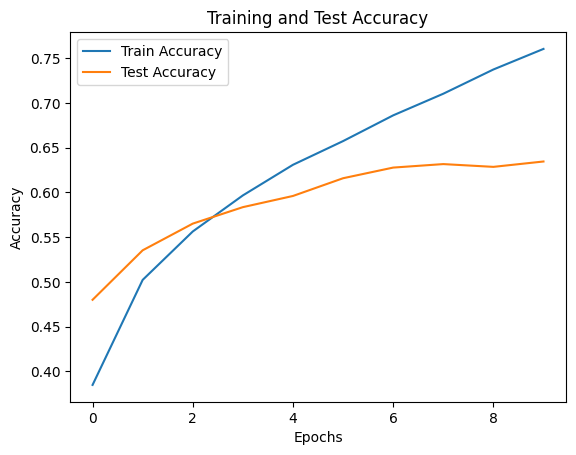

In [77]:
plt.plot(train_accuracies, label = "Train Accuracy")
plt.plot(test_accuracies, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [78]:
import random

In [85]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [89]:
def predict_and_plot_grid(
    model,
    dataset,
    classes,
    grid_size=3):
  model.eval()
  fig,axes = plt.subplots(grid_size, grid_size, figsize = (9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0,len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data,1)
      img = img/2 +0.5 #unnormalize images to be able to plot with matplotlib
      npimg = img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg, (1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"

      axes[i,j].set_title(f"Truth:{classes[true_label]}\n, Predicted:{classes[predicted.item()]}",fontsize = 10, c=color)
      axes[i,j].axis("off")
  plt.tight_layout()

  plt.show()



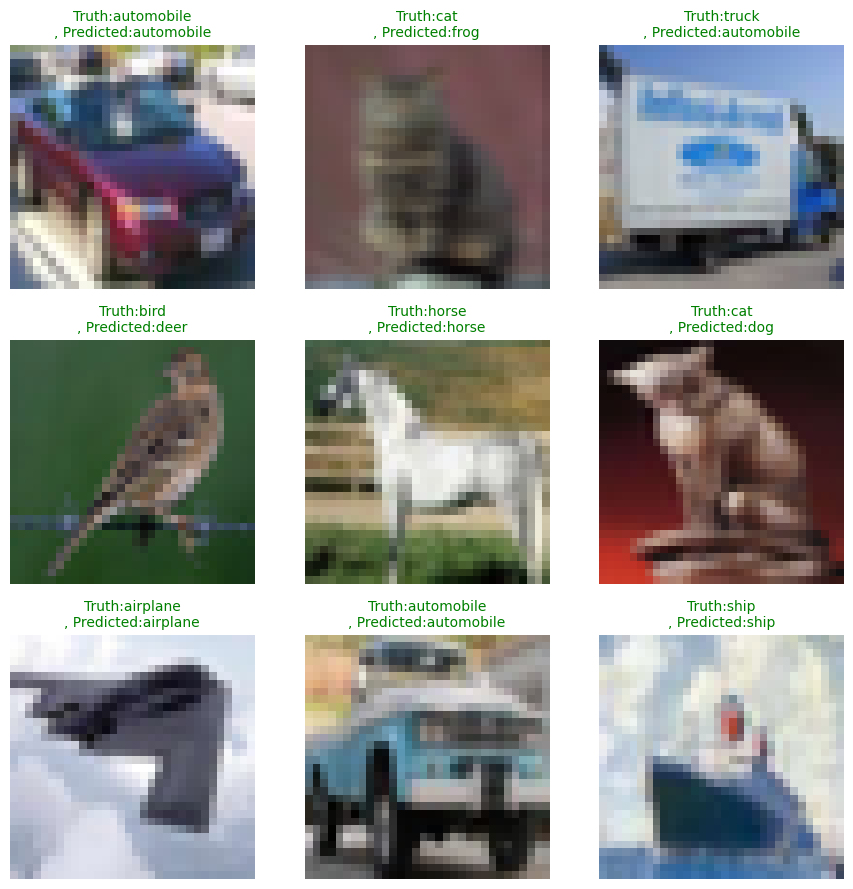

In [96]:
predict_and_plot_grid(model,test_dataset, classes= train_dataset.classes, grid_size=3)